In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
from sklearn import preprocessing
from sklearn.covariance import OAS, EmpiricalCovariance, EllipticEnvelope, GraphicalLassoCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_approximation import Nystroem

plt.style.use("seaborn-v0_8")

In [3]:
random_state = 42

df = pd.read_csv("train.csv").drop_duplicates()

# "stratify" is set because the target is very imbalanced
train, test = train_test_split(df, stratify=df["Year"], test_size=0.3, random_state=random_state)
val, test = train_test_split(test, stratify=test["Year"], test_size=1 / 3, random_state=random_state)

X_train = train.drop(columns=["Year"])
y_train = train["Year"]

X_val = val.drop(columns=["Year"])
y_val = val["Year"]

X_test = test.drop(columns=["Year"])
y_test = test["Year"]

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

print("X_train: {}\nX_val: {}\nX_test: {}".format(X_train.shape, X_val.shape, X_test.shape))
print("\nX_train_val: {}, y_train_val: {}".format(X_train_val.shape, y_train_val.shape))

X_train: (176486, 90)
X_val: (50424, 90)
X_test: (25213, 90)

X_train_val: (226910, 90), y_train_val: (226910,)


---
# Preprocessing

- [Whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation) is tested
- [Shrinkage, Oracle Approximating Shrinkage (OAS)](https://en.wikipedia.org/wiki/Shrinkage_(statistics)#:~:text=In%20statistics%2C%20shrinkage%20is%20the,coefficient%20of%20determination%20'shrinks') is tested because requires normal distributed data
- [Empirical covariance](https://scikit-learn.org/stable/modules/covariance.html#empirical-covariance) is tested because requires normal distributed data
- [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) is tested because it's robust to anomalies, requires normal and unimodal distributed data
- LDA with eigenvalues solver for dimensionality reduction

In [173]:
# step_name, [(transformer_name, transformer_constructor()), ...], step_param_grid
transformers_list = [
    # ("raw", [("raw", "passthrough")], {}),  # does nothing to the data
    # ("std-scaled", [("std-scaler", preprocessing.StandardScaler())], {}),
    # ("min-maxed", [("min-max", preprocessing.MinMaxScaler())], {}),
    # (
    #     "std-scaler + pca 0.95",
    #     [
    #         ("std-scaler", preprocessing.StandardScaler()),
    #         ("pca", PCA(random_state=random_state)),
    #     ],
    #     {
    #         "pca__svd_solver": ["full"],
    #         "pca__n_components": [0.95],
    #         "pca__whiten": [True, False],
    #     },
    # ),
    # (
    #     "min-max + pca 0.95",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("pca", PCA(random_state=random_state)),
    #     ],
    #     {
    #         "pca__svd_solver": ["full"],
    #         "pca__n_components": [0.95],
    #         "pca__whiten": [True, False],
    #     },
    # ),
    # (
    #     "min-max + lmax + pca 0.95",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("lmax", preprocessing.Normalizer(norm="max")),
    #         ("pca", PCA(random_state=random_state)),
    #     ],
    #     {
    #         "pca__svd_solver": ["full"],
    #         "pca__n_components": [0.95],
    #         "pca__whiten": [True, False],
    #     },
    # ),
    # (
    #     "min-max + lda",
    #     [("min-max", preprocessing.MinMaxScaler()), ("lda", LinearDiscriminantAnalysis())],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__shrinkage": [None],
    #         "lda__covariance_estimator": [
    #             # EllipticEnvelope(random_state=random_state, contamination=0.001),
    #             # EmpiricalCovariance(),
    #             OAS(),
    #             # None,
    #         ],
    #     },
    # ),
    # (
    #     "min-max + lmax + lda",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("lmax", preprocessing.Normalizer(norm="max")),
    #         ("lda", LinearDiscriminantAnalysis()),
    #     ],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__shrinkage": [None],
    #         "lda__covariance_estimator": [
    #             # EllipticEnvelope(random_state=random_state, contamination=0.001),
    #             # EmpiricalCovariance(),
    #             OAS(),
    #             # None,
    #         ],
    #     },
    # ),
    # (
    #     "min-max + nystroem",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
    #     ],
    #     {
    #         "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
    #         "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
    #     },
    # ),
    # (
    #     "min-max + lda + nystroem",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("lda", LinearDiscriminantAnalysis()),
    #         ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
    #     ],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__covariance_estimator": [OAS()],
    #         "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
    #         "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
    #     },
    # ),
    # (
    #     "std-scaler + lda + nystroem",
    #     [
    #         ("std-scaler", preprocessing.StandardScaler()),
    #         ("lda", LinearDiscriminantAnalysis()),
    #         ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
    #     ],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__covariance_estimator": [OAS()],
    #         "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
    #         "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
    #     },
    # ),
    (
        "min-max + l1 + lda + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("l1", preprocessing.Normalizer(norm="l1")),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    ),
]

---
---
# Modeling
- For every preprocess method defined above, execute a GridSearch over the preprocess parameters plus the model parameters
- Then it's chosen the best model with the best preprocess method looking at the R^2 score
- "StratifiedKFold" is chosen to keep the proportion of imbalanced target lables

In [181]:
def print_all_results(name_estimator):
    df = pd.read_csv("1_" + name_estimator + "_output.csv")
    display(
        df[[col for col in df.columns if col not in ["MSE", "R^2"]] + ["MSE", "R^2"]]
        .sort_values(by="R^2", ascending=False)
        .style.format(precision=7)
    )

In [189]:
import plotly.graph_objects as go


def save_display_results(
    name_estimator,
    best_preprocessor,
    best_estimator,
    best_predictions,
):

    file = open("1_" + name_estimator + "_preproc_" + ".save", "wb")
    pickle.dump(best_preprocessor, file)
    file = open("1_" + name_estimator + "_model_" + ".save", "wb")
    pickle.dump(best_estimator, file)
    file.close()

    # Show confusion matrix of best result
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(None)
    fig.tight_layout()
    cmp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        np.round(best_predictions).astype(int),
        ax=ax,
        # xticks_rotation=80,
        include_values=False,
        cmap="gist_stern",  # "magma",
        colorbar=False,
    )
    ax.set_xticks(range(0, len(cmp.confusion_matrix), 5))
    ax.set_yticks(range(0, len(cmp.confusion_matrix), 5))
    ax.plot(range(len(cmp.confusion_matrix)), range(len(cmp.confusion_matrix)), color="white", linestyle="dotted")
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(cmp.im_, cax=cax)
    plt.show()

    # Show Parallel graph
    df = pd.read_csv("1_" + name_estimator + "_output.csv")
    df["R^2"] = df["R^2"].round(2)
    df["MSE"] = df["MSE"].round(2)

    for col in df.columns:
        if col not in ["R^2", "MSE"]:
            df[col] = df[col].fillna("None")
            df[col] = df[col].astype("object")

    dimensions = []

    for col in df.select_dtypes(include="object"):
        if col not in ["R^2", "MSE"]:
            unique_dict = {i: num for num, i in enumerate(df[col].unique())}
            df[col] = df[col].map(unique_dict)
            dimensions.append(
                dict(
                    label=str(col),
                    values=df[col],
                    tickvals=list(unique_dict.values()),
                    ticktext=list(unique_dict.keys()),
                )
            )

    for col in ["R^2", "MSE"]:
        dimensions.append(dict(label=str(col), values=df[col]))

    fig = go.Figure(
        data=go.Parcoords(
            line=dict(color=df["MSE"], colorscale="viridis", showscale=True), dimensions=dimensions, labelangle=-15
        )
    )

    fig.update_traces(
        dimensions=[
            {
                **d,
                **{
                    "tickvals": np.round(
                        np.linspace(min(d["values"]), max(d["values"]), len(np.unique(d["values"]))), 2
                    )
                },
            }
            for d in fig.to_dict()["data"][0]["dimensions"]
        ]
    )

    # fig.update_layout(
    #     paper_bgcolor="floralwhite",
    # )

    fig.show()

In [184]:
test_fold = np.zeros(X_train_val.shape[0])
test_fold[: X_train.shape[0]] = -1  # exclude the train set, setting the train indexes to -1
ps = PredefinedSplit(test_fold)


def gridSearch(name_estimator, estimator, param_estimator, save):
    best_r2_score = float("-inf")
    best_MSE_score = float("inf")
    best_preprocessor = []
    best_estimator = None
    best_name_step = None
    best_predictions = []
    best_params = {}

    for name_step, transformers, param_transformers in transformers_list:
        pipe = Pipeline([*transformers, (name_estimator, estimator)])
        gs = GridSearchCV(
            pipe,
            param_grid={**param_estimator, **param_transformers},
            scoring="r2",
            n_jobs=-1,
            cv=ps,
            # verbose=3,
            pre_dispatch=8,
        )

        # Fit
        gs.fit(X_train_val, y_train_val)
        # Predict
        y_pred = gs.predict(X_test.values)
        # Test scores
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2_score:
            best_r2_score = r2
            best_MSE_score = mse
            best_name_step = name_step
            best_preprocessor = gs.best_estimator_[:-1]  # take all but the estimator
            best_estimator = gs.best_estimator_[-1]
            best_params = gs.best_params_
            best_predictions = y_pred

    # Show best result
    print(
        "Best:\n\t{} data\n\tParams: {}\n\tR^2: {}\n\tMSE: {}".format(
            best_name_step, best_params, best_r2_score, best_MSE_score
        )
    )

    # Save in csv the best result
    if save:
        results = pd.DataFrame(best_params or None, index=[0])
        results = results.assign(preprocess=best_name_step, MSE=best_MSE_score, R2=best_r2_score).rename(
            columns={"R2": "R^2"}
        )
        file_name = "1_" + name_estimator + "_output.csv"
        results = pd.concat([pd.read_csv(file_name) if os.path.isfile(file_name) else pd.DataFrame(), results], axis=0)
        results.to_csv(file_name, index=False)

    return (
        best_preprocessor,
        best_estimator,
        best_predictions,
    )

---
## Linear Regression

In [186]:
param_estimator = {}

name_estimator = "lr"

best_preprocessor, best_estimator, best_predictions = gridSearch(
    name_estimator,
    LinearRegression(n_jobs=-1),
    param_estimator,
    False,
)

Best:
	min-max + l1 + lda + nystroem data
	Params: {'lda__covariance_estimator': OAS(), 'lda__solver': 'eigen', 'nys__gamma': 0.01, 'nys__n_components': 1000}
	R^2: 0.33129078196843664
	MSE: 73.6070027469092


In [187]:
print_all_results(name_estimator)

,preprocess,pca__n_components,pca__svd_solver,pca__whiten,lda__covariance_estimator,lda__shrinkage,lda__solver,nys__gamma,nys__n_components,MSE,R^2
11,min-max + lda + nystroem,nan,nan,nan,OAS(),nan,eigen,0.0100000,1000.0000000,73.5979577,0.3313730
8,min-max + lmax + lda + nystroem,nan,nan,nan,OAS(),nan,eigen,0.0100000,1000.0000000,73.6178914,0.3311919
10,std-scaler + lda + nystroem,nan,nan,nan,OAS(),nan,eigen,0.0100000,1000.0000000,74.3452920,0.3245835
9,min-max + nystroem,nan,nan,nan,nan,nan,nan,0.0100000,1000.0000000,75.8561394,0.3108577
7,min-max + lmax + lda,nan,nan,nan,EmpiricalCovariance(),nan,eigen,nan,nan,83.3157626,0.2430881
12,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,nan,nan,83.3398224,0.2428695
6,min-max + lda,nan,nan,nan,EmpiricalCovariance(),nan,eigen,nan,nan,83.9731990,0.2371154
2,min-maxed,nan,nan,nan,nan,nan,nan,nan,nan,83.9731990,0.2371154
1,std-scaled,nan,nan,nan,nan,nan,nan,nan,nan,83.9731990,0.2371154
0,raw,nan,nan,nan,nan,nan,nan,nan,nan,83.9731990,0.2371154


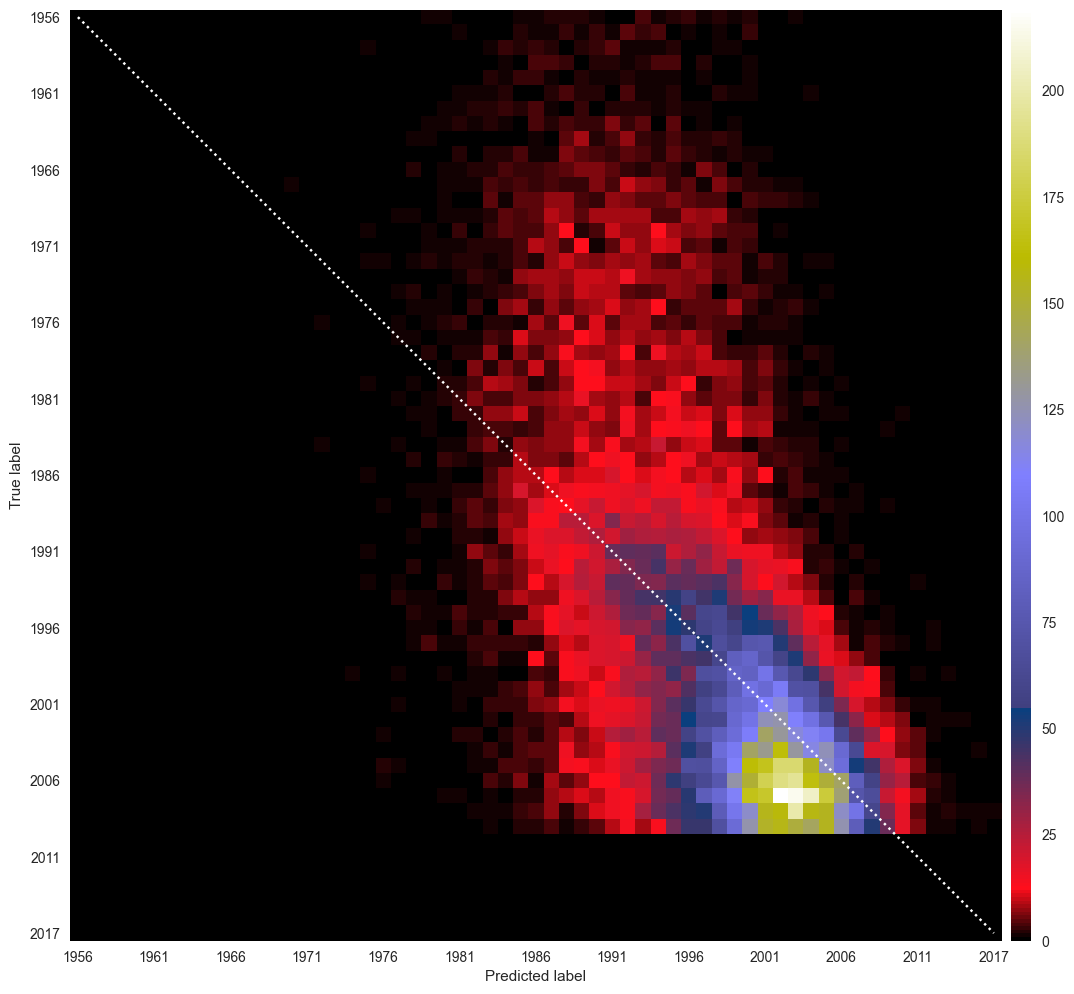

In [190]:
save_display_results(
    name_estimator,
    best_preprocessor,
    best_estimator,
    best_predictions,
)

---
## RandomForestRegressor
- PCA gives worse results than LDA.
- LDA gives the best results with MinMax + Lmax-Normalization.
- The following results are given with a preprocess of MinMax + Lmax-Normalization + LDA:
    - Keeping the number of trees to 200 with samples percentage per tree of 10% (for computational reasons):
        - The best covariance estimators are EllipticEnvelope (MinCovDet) and OAS, over EmpiricalCovariance and no-shrinkage: R^2=0.3033, MSE=76.77
        - The best "contamination" amount for EllipticEnvelope is 0.001, over 0.2, 0.1, 0.05, 0.0001, but the difference is minimal
        - The only difference is that the OAS covariance estimator takes much less time to compute instead of EllipticEnvelope
    - Incrementing the number of trees (500) and reducing the percentage of samples per tree (2.5%) (for computational reasons), the results were a bit worse but very similar
    - Decrementing the number of trees (5) with samples percentage per tree of 100%, the results are far worse (R^2=0.16, MSE=92)
- Therefore the best combination is:
    - MinMax preprocess + l-max-Normalization + LDA preprocess with OAS covariance estimator and "eigen" as solver
    - RandomForest with 200 estimators and 100% of sample per estimator: R^2=0.3195, MSE=74.98
    - There is a very big downside with this configuration: it is more than 2GB of model size, in comparison with the 328MB of the same model but with 0.1% of samples per tree (the results are the one above).

In [191]:
param_estimator = {
    "rf__max_samples": [1.0],
    "rf__criterion": ["squared_error"],
    "rf__n_estimators": [200],
}

name_estimator = "rf"

best_preprocessor, best_estimator, best_predictions = gridSearch(
    name_estimator,
    RandomForestRegressor(n_jobs=-1),
    param_estimator,
    False,
)

Best:
	min-max + l1 + lda + nystroem data
	Params: {'lda__covariance_estimator': OAS(), 'lda__solver': 'eigen', 'nys__gamma': 0.01, 'nys__n_components': 1000, 'rf__criterion': 'squared_error', 'rf__max_samples': 1, 'rf__n_estimators': 1}
	R^2: -2.736753388248617
	MSE: 411.316622377345


In [192]:
print_all_results(name_estimator)

,rf__criterion,rf__max_samples,rf__n_estimators,preprocess,pca__n_components,pca__svd_solver,pca__whiten,lda__covariance_estimator,lda__shrinkage,lda__solver,MSE,R^2
15,squared_error,1.0000000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,74.7329429,0.3210618
13,squared_error,0.2500000,500.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,75.1682140,0.3171074
9,squared_error,0.1000000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,76.2823513,0.3069856
6,squared_error,0.1000000,200.0000000,min-max + lda,nan,nan,nan,OAS(),nan,eigen,76.6464378,0.3036779
12,squared_error,0.1000000,200.0000000,min-max + lmax + lda,nan,nan,nan,"EllipticEnvelope(contamination=0.001, random_state=42)",nan,eigen,76.7616914,0.3026309
11,squared_error,0.1000000,200.0000000,min-max + lmax + lda,nan,nan,nan,EmpiricalCovariance(),nan,eigen,76.9040794,0.3013373
8,squared_error,0.1000000,200.0000000,min-max + lda,nan,nan,nan,"EllipticEnvelope(contamination=0.001, random_state=42)",nan,eigen,76.9266211,0.3011325
10,squared_error,0.1000000,200.0000000,min-max + lmax + lda,nan,nan,nan,nan,nan,eigen,77.0583812,0.2999355
5,squared_error,0.1000000,200.0000000,min-max + lda,nan,nan,nan,nan,nan,eigen,77.2597685,0.2981059
7,squared_error,0.1000000,200.0000000,min-max + lda,nan,nan,nan,EmpiricalCovariance(),nan,eigen,77.2882143,0.2978475


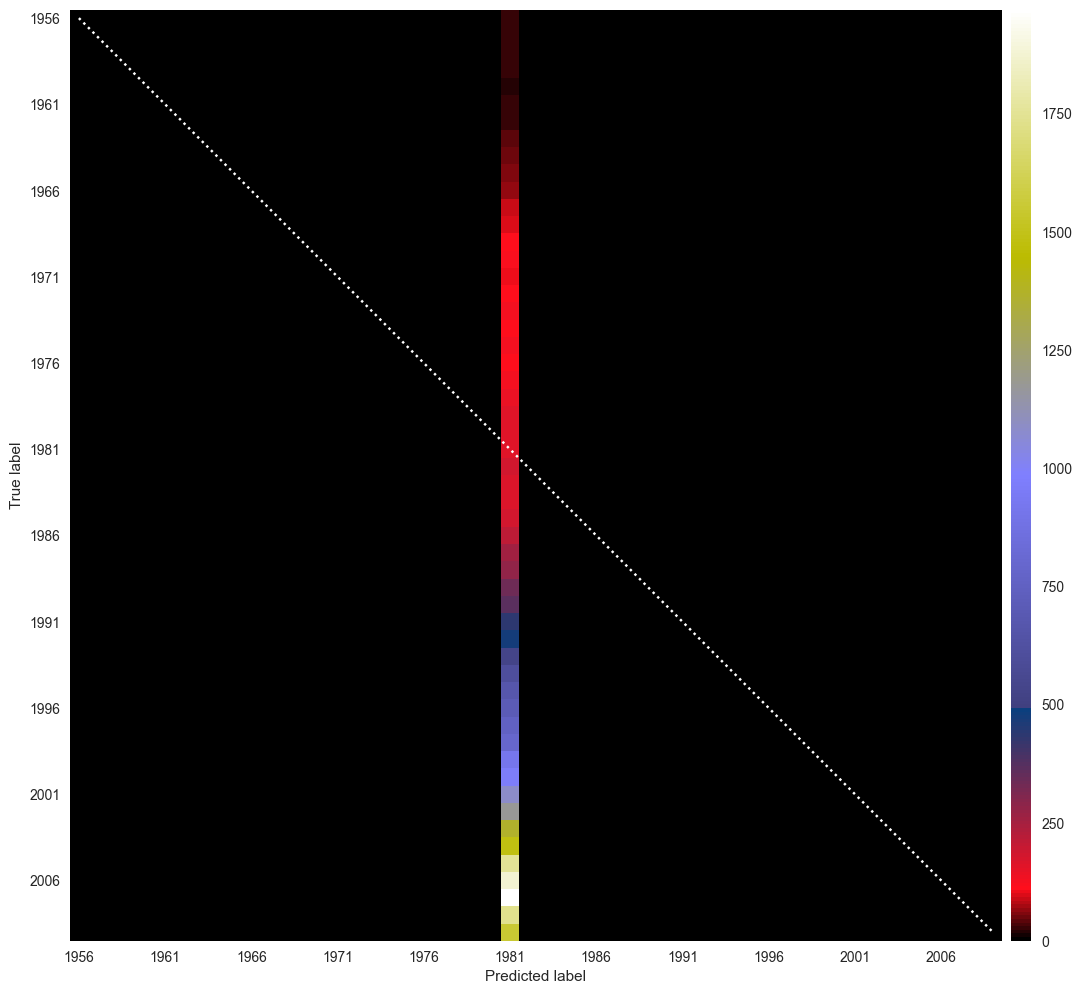

In [193]:
save_display_results(
    name_estimator,
    best_preprocessor,
    best_estimator,
    best_predictions,
)

---
## KNN
- PCA with an explained variance ratio of 0.95 performs much better with a min-max scaling (54 components) instead of a standard-scaling (67 components) and min-max + standard-scaling.
- The following search was not exhaustive: we not try all the possible combinations, but we followed the more promising paths
- The best result is R^2=0.3224 , MSE=74.66 with:
    - MinMax + l-max-Normalization + LDA. It performed better than PCA (and its combinations with preprocessing techniques), l-1-Normalization + LDA, l-2-Normalization + LDA, MinMax + l-1-Normalization + LDA, MinMax + l-2-Normalization + LDA
    - Best covariance estimator for LDA is OAS, over EllipticEnvelope, EmpiricalCovariance and no-shrinkage
    - Best KNN metric is cosine, over cityblock, euclidean, nan_euclidean, with "weights"="distance" over "uniform"
    - Best number of neighbors is 20 (tried in this order 5,30,25,20,15,17,18,19)

In [194]:
param_estimator = {
    "knr__n_neighbors": [21],
    "knr__weights": ["distance"],  # "uniform"
    "knr__metric": [
        # "cityblock",
        "cosine",
        # "euclidean",
        # "nan_euclidean",
    ],
}

name_estimator = "knr"

best_preprocessor, best_estimator, best_predictions = gridSearch(
    name_estimator,
    KNeighborsRegressor(n_jobs=-1),
    param_estimator,
    False,
)

Best:
	min-max + l1 + lda + nystroem data
	Params: {'knr__metric': 'cosine', 'knr__n_neighbors': 20, 'knr__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__solver': 'eigen', 'nys__gamma': 0.01, 'nys__n_components': 1000}
	R^2: 0.33557361840345756
	MSE: 73.13557698405651


In [195]:
print_all_results(name_estimator)

,knr__metric,knr__n_neighbors,knr__weights,lda__covariance_estimator,lda__shrinkage,lda__solver,preprocess,pca__n_components,pca__svd_solver,pca__whiten,MSE,R^2
17,cosine,21,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,73.6558730,0.3308468
8,cosine,25,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,73.6801573,0.3306262
18,cosine,23,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,73.6836591,0.3305944
1,cosine,20,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,73.6861822,0.3305714
10,cosine,20,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,73.6861822,0.3305714
7,cosine,20,distance,OAS(),nan,eigen,min-max + l1 + lda,nan,nan,nan,73.8715901,0.3288870
2,cosine,20,distance,OAS(),nan,eigen,min-max + lda,nan,nan,nan,73.9038913,0.3285936
12,cosine,20,distance,nan,nan,nan,min-maxed,nan,nan,nan,74.5819594,0.3224334
14,cosine,20,distance,nan,nan,eigen,min-max + lmax + lda,nan,nan,nan,74.9271332,0.3192976
3,cosine,20,distance,EmpiricalCovariance(),nan,eigen,min-max + lmax + lda,nan,nan,nan,74.9271332,0.3192976


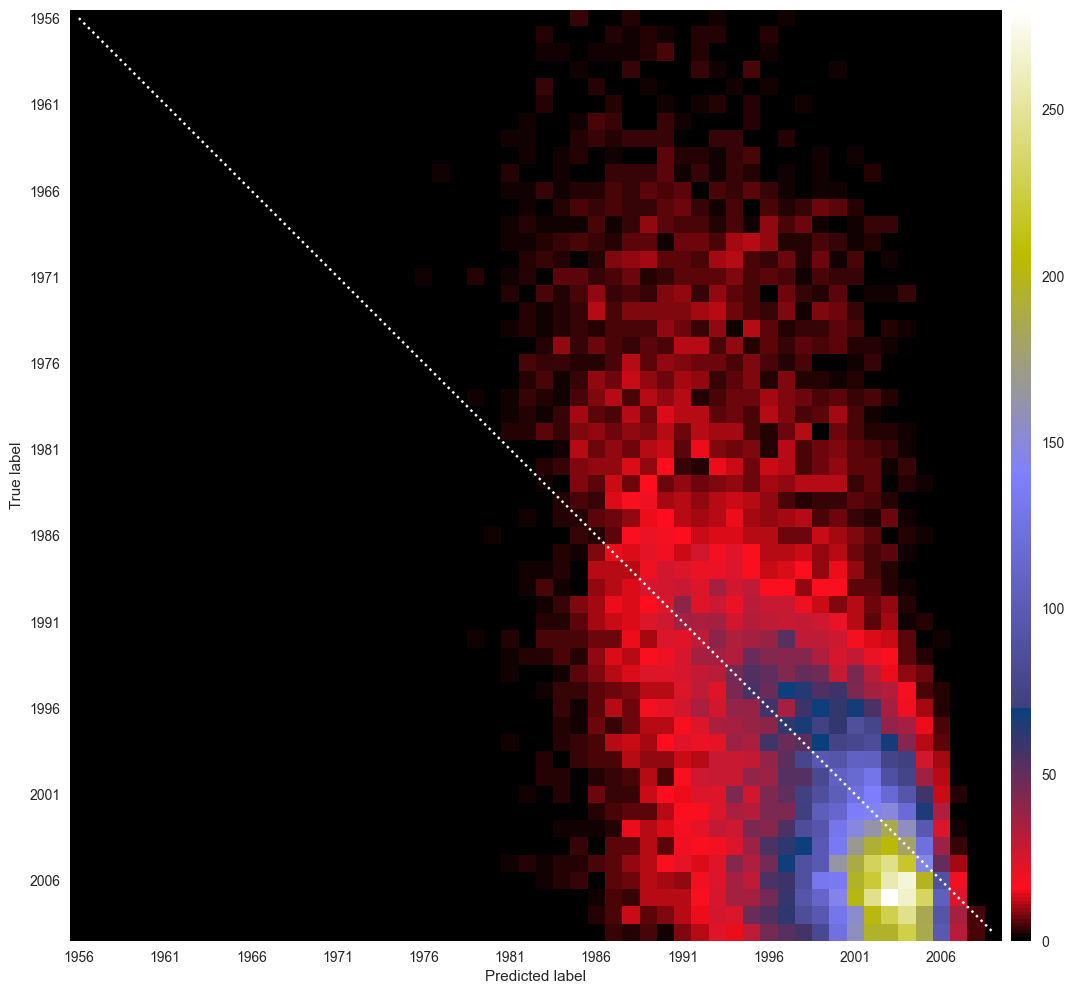

In [200]:
save_display_results(
    name_estimator,
    best_preprocessor,
    best_estimator,
    best_predictions,
)

---
## SVM

In [ ]:
param_estimator = {
    "svr__epsilon": [0.01],
    "svr__C": [10],  # 0.1, 1, 100, 500, 5, 20, 8, 9,15
    "svr__max_iter": [2000],
}

name_estimator = "svr"

best_preprocessor, best_estimator, best_predictions = gridSearch(
    name_estimator,
    LinearSVR(dual="auto", random_state=random_state),
    param_estimator,
    False,
)

In [198]:
print_all_results(name_estimator)

,lda__covariance_estimator,lda__solver,nys__gamma,nys__n_components,preprocess,pca__n_components,pca__svd_solver,pca__whiten,svr__C,svr__epsilon,svr__max_iter,MSE,R^2
8,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,10.0000000,0.0100000,2000.0000000,78.7212330,0.2848287
9,OAS(),eigen,0.0100000,1000.0000000,min-max + lda + nystroem,nan,nan,nan,10.0000000,0.0100000,2000.0000000,78.9061170,0.2831491
10,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,10.0000000,nan,2000.0000000,78.9567844,0.2826888
2,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,nan,nan,nan,79.2911086,0.2796515
1,OAS(),eigen,0.0100000,1000.0000000,min-max + lmax + lda + nystroem,nan,nan,nan,nan,nan,nan,79.4122769,0.2785507
7,OAS(),eigen,0.0100000,1000.0000000,min-max + l2 + lda + nystroem,nan,nan,nan,nan,nan,nan,79.5118577,0.2776460
5,OAS(),eigen,0.0100000,1000.0000000,min-max + lda + nystroem,nan,nan,nan,nan,nan,nan,79.5140189,0.2776264
6,OAS(),eigen,0.0100000,1000.0000000,std-scaler + lda + nystroem,nan,nan,nan,nan,nan,nan,79.6422640,0.2764613
3,nan,nan,0.0100000,1000.0000000,min-max + pca 0.95 + nystroem,0.9500000,full,True,10.0000000,0.0100000,2000.0000000,79.7303619,0.2756609
4,OAS(),eigen,0.0100000,1000.0000000,min-max + nystroem,nan,nan,nan,nan,nan,nan,102.2867139,0.0707397


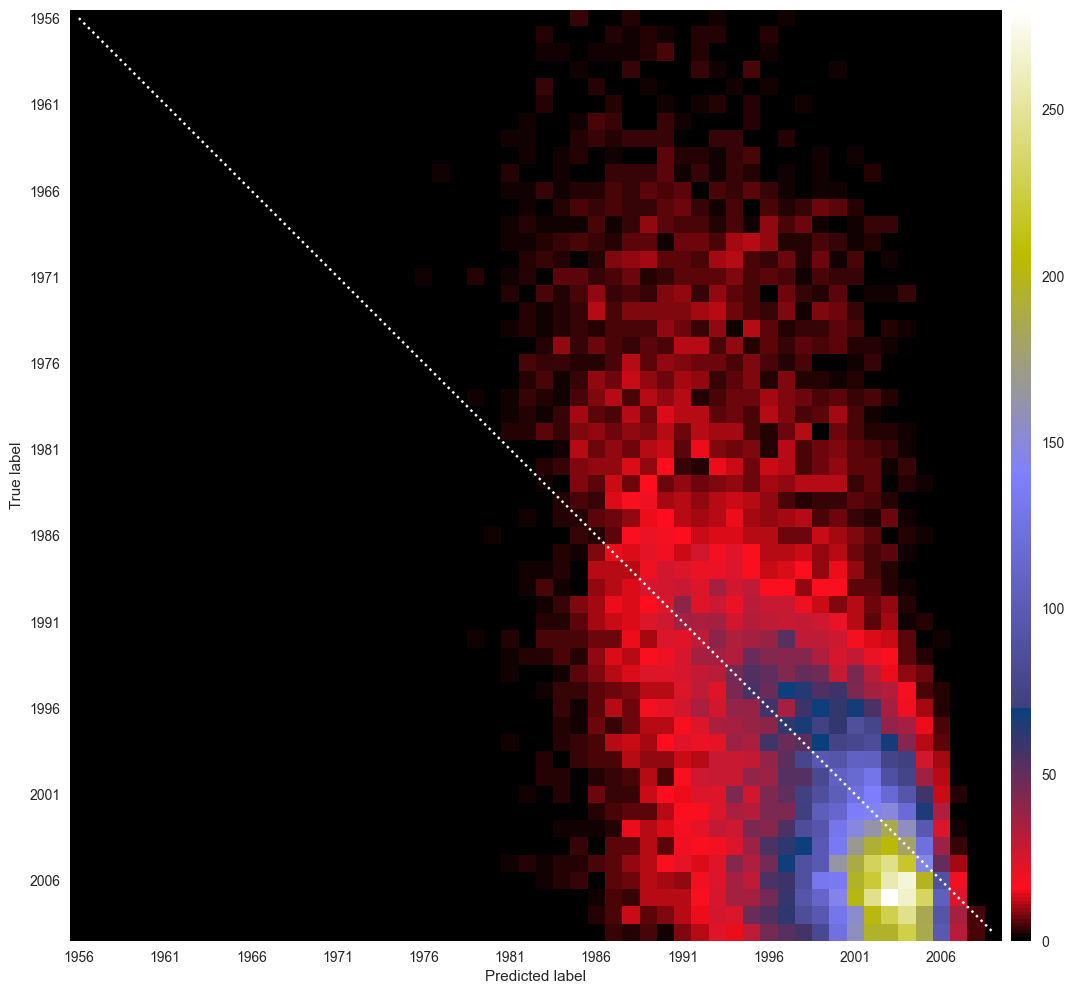

In [199]:
save_display_results(
    name_estimator,
    best_preprocessor,
    best_estimator,
    best_predictions,
)